In [1]:
import numpy as np
import pandas as pd
import cv2
import pickle
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential, load_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [3]:
train_df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8') # to save memory

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200840 entries, 0 to 200839
Data columns (total 5 columns):
image_id               200840 non-null object
grapheme_root          200840 non-null uint8
vowel_diacritic        200840 non-null uint8
consonant_diacritic    200840 non-null uint8
grapheme               200840 non-null object
dtypes: object(2), uint8(3)
memory usage: 3.6+ MB


In [5]:
train_df.drop('grapheme', axis= 1, inplace= True)

In [6]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic
0,Train_0,15,9,5
1,Train_1,159,0,0
2,Train_2,22,3,5
3,Train_3,53,2,2
4,Train_4,71,9,5


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200840 entries, 0 to 200839
Data columns (total 4 columns):
image_id               200840 non-null object
grapheme_root          200840 non-null uint8
vowel_diacritic        200840 non-null uint8
consonant_diacritic    200840 non-null uint8
dtypes: object(1), uint8(3)
memory usage: 2.1+ MB


In [8]:
train_imgs0 = pd.read_parquet("data/train_image_data_0.parquet")
train_imgs0.info()

In [9]:
train_imgs1 = pd.read_parquet("data/train_image_data_1.parquet")
train_imgs1.info()

In [10]:
train_imgs2 = pd.read_parquet("data/train_image_data_2.parquet")
train_imgs2.info()

In [11]:
train_imgs3 = pd.read_parquet("data/train_image_data_3.parquet")
train_imgs3.info()

In [12]:
train_imgs = pd.concat(
                    [train_imgs0, train_imgs1, train_imgs2, train_imgs3],
                    ignore_index= True)
train_imgs.info()

In [13]:
del train_imgs0, train_imgs1, train_imgs2, train_imgs3

In [14]:
img_id = train_imgs['image_id']

In [15]:
train_imgs.drop('image_id', axis= 1, inplace= True)

In [16]:
from data_functions import resize

In [ ]:
train_imgs_resized = resize(train_imgs)

In [18]:
del train_imgs

In [19]:
train_imgs_resized['image_id'] = img_id

In [20]:
train_df = train_df.merge(train_imgs_resized, on= 'image_id')
train_df.head()

In [21]:
train_df.info()

In [22]:
# pickle.dump(train_df, open('cleaned_training.p', 'wb'))

In [23]:
train_df = pickle.load(open('cleaned_training.p', 'rb'))

In [24]:
from data_functions import create_training_data

In [25]:
X, Y_root, Y_vowel, Y_consonant = create_training_data(train_df)

In [26]:
x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X, Y_root, Y_vowel, Y_consonant, test_size=0.05, random_state=42)
y_train = [y_train_root, y_train_vowel, y_train_consonant]
y_test = [y_test_root, y_test_vowel, y_test_consonant]

In [27]:
inputs = Input(shape = (64, 64, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(64, 64, 1))(inputs)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
dense = Dense(1024, activation = "relu")(model)

root = Dense(168, activation = 'softmax')(dense)
vowel = Dense(11, activation = 'softmax')(dense)
consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[root, vowel, consonant])

In [28]:
from create_models import ModelEvaluation

In [29]:
mymodel = ModelEvaluation(model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [30]:
mymodel.train(x_train, y_train,
              epochs= 10, 
              batch_size= 256, 
              validation_split= 0.1)

Train on 171718 samples, validate on 19080 samples
Epoch 1/10
171718/171718 [==============================] - 111s 648us/step - loss: 6.5610 - dense_2_loss: 4.3053 - dense_3_loss: 1.2662 - dense_4_loss: 0.9891 - dense_2_accuracy: 0.0919 - dense_3_accuracy: 0.6258 - dense_4_accuracy: 0.6955 - val_loss: 5.3073 - val_dense_2_loss: 3.6829 - val_dense_3_loss: 0.9073 - val_dense_4_loss: 0.7184 - val_dense_2_accuracy: 0.1551 - val_dense_3_accuracy: 0.6782 - val_dense_4_accuracy: 0.7440
Epoch 2/10
171718/171718 [==============================] - 106s 619us/step - loss: 4.7144 - dense_2_loss: 3.3529 - dense_3_loss: 0.7230 - dense_4_loss: 0.6384 - dense_2_accuracy: 0.2050 - dense_3_accuracy: 0.7518 - dense_4_accuracy: 0.7741 - val_loss: 4.5258 - val_dense_2_loss: 3.1897 - val_dense_3_loss: 0.7294 - val_dense_4_loss: 0.6074 - val_dense_2_accuracy: 0.2320 - val_dense_3_accuracy: 0.7477 - val_dense_4_accuracy: 0.7836
Epoch 3/10
171718/171718 [==============================] - 106s 619us/step - los

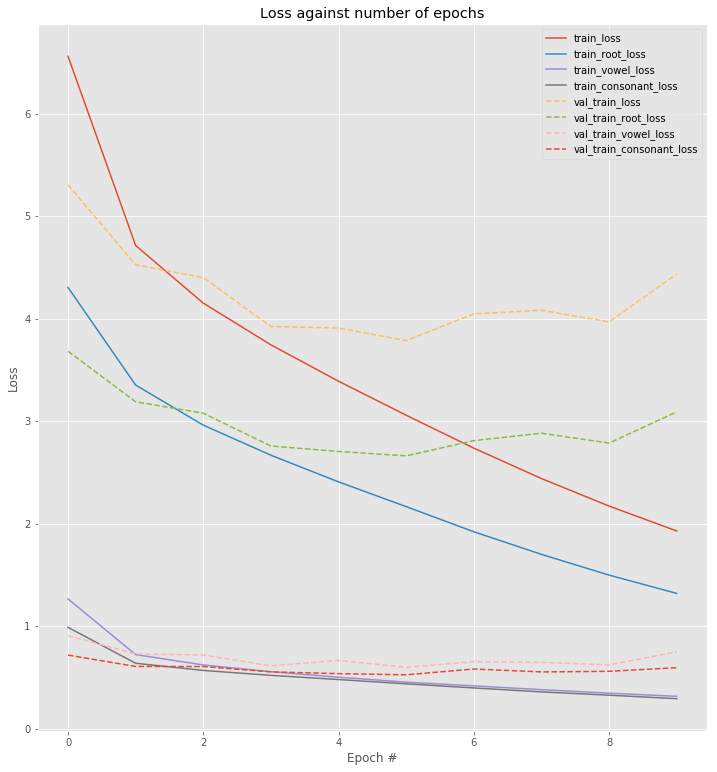

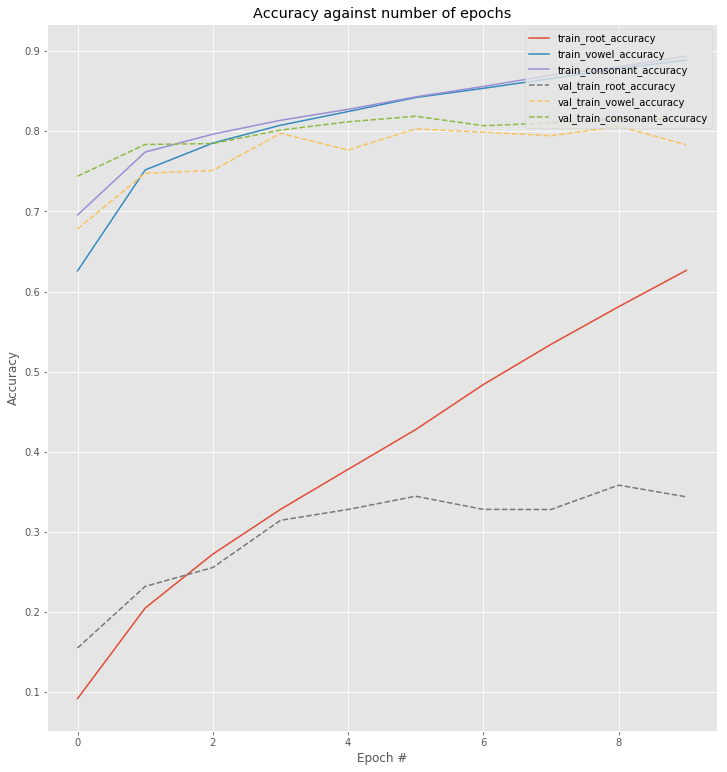

In [31]:
mymodel.plot_metrics()

In [33]:
mymodel.save_model()

In [36]:
mymodel.hist.history

{'dense_2_accuracy': [0.091883205,
  0.20501053,
  0.2722836,
  0.32809606,
  0.37809083,
  0.42778277,
  0.48395625,
  0.5341199,
  0.5810748,
  0.62639326],
 'dense_2_loss': [4.30525,
  3.3529003,
  2.9616535,
  2.6683662,
  2.408111,
  2.1668198,
  1.9215361,
  1.7009956,
  1.4985046,
  1.3202912],
 'dense_3_accuracy': [0.6257993,
  0.7518024,
  0.7853341,
  0.8075624,
  0.8246893,
  0.8422006,
  0.85367286,
  0.86583817,
  0.8784111,
  0.88880026],
 'dense_3_loss': [1.2662437,
  0.7230252,
  0.62194663,
  0.5563867,
  0.5023185,
  0.45407218,
  0.41793635,
  0.3809941,
  0.34654135,
  0.3159117],
 'dense_4_accuracy': [0.69554734,
  0.7741064,
  0.79645115,
  0.8137469,
  0.82744384,
  0.8429809,
  0.85601395,
  0.87007767,
  0.88057745,
  0.8937211],
 'dense_4_loss': [0.98906815,
  0.6384089,
  0.5686041,
  0.5205225,
  0.47970408,
  0.43768403,
  0.39773968,
  0.35901955,
  0.3272436,
  0.29296318],
 'loss': [6.561029507796493,
  4.714430020381132,
  4.152274838080814,
  3.7452868

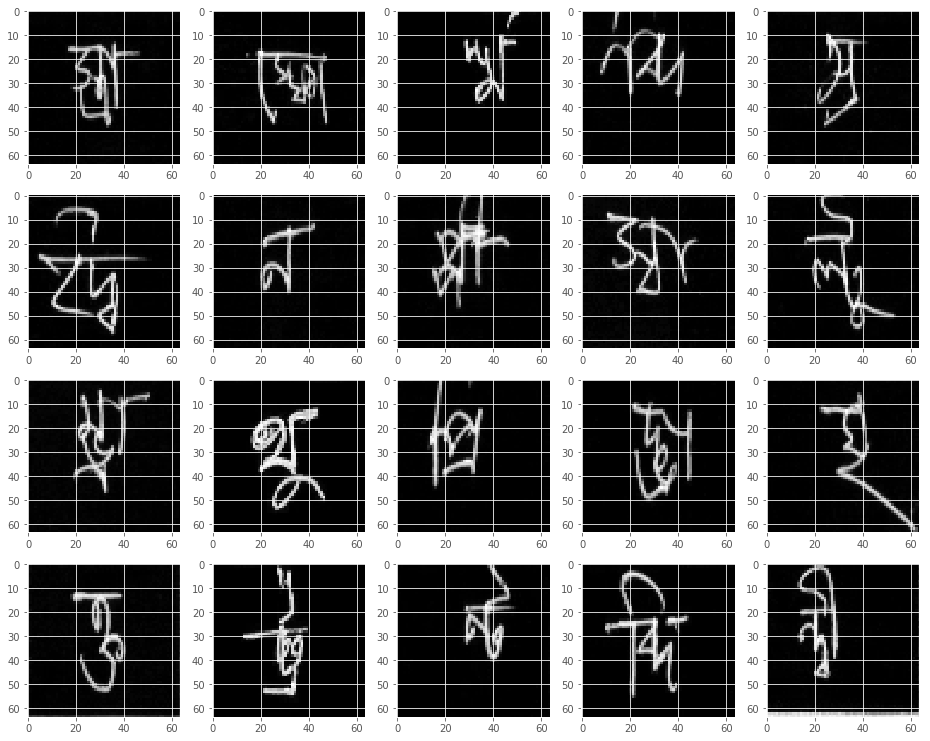

predicted                 true                
              root vowel consonant root vowel consonant
image_0        133     1         5  150     1         5
image_1        145     9         0  154     9         0
image_2        120     7         2  120     0         2
image_3        117     8         0  109     2         0
image_4        147     4         5  147     0         5
image_5         76     7         0   76     8         0
image_6         81     0         0   81     0         0
image_7        100     3         0  100     3         0
image_8        140     1         0  155     1         0
image_9        127     4         0  127     4         0
image_10       149     1         5  119     1         5
image_11        71     4         0   71     4         0
image_12        96     2         5   96     2         5
image_13       119     1         0   77     1         5
image_14       151     4         0   29     6         0
image_15       148     0         5   16     0         0
image_16        53     1         5   53     0         5
image_17       149     0         0   60     0         0
image_18       109     2         0  109     2         0
image_19       149     3         0   90     3         0

In [39]:
mymodel.test(x_test, y_test, 20)

In [40]:
mymodel.evaluation(x_test, y_test)

10042/10042 [==============================] - 5s 466us/step
{'dense_3_accuracy': 0.78211510181427, 'dense_3_loss': 0.7515246868133545, 'dense_2_accuracy': 0.3452499508857727, 'dense_2_loss': 3.0916659832000732, 'dense_4_loss': 0.5669087171554565, 'loss': 4.4090138403834205, 'dense_4_accuracy': 0.8291177153587341}
